# ДЗ1 - имитационное обучение
Крайний срок сдачи - 20.02.2019 23:59.

***
Задача будет заключаться в том, чтобы провести эксперименты с имитационным обучением: смотреть, что такое клонирование поведеня и разобраться с алгоритмом DAgger.
Вместо человека-демонстранта демонстрации будут даваться специальной предобученной "экспертной" стартегией. Ваша задача будет заключаться в реализации алгоритма клонирования и DAgger, сравнения их произвоодительости на нескольких простых задачах управления из пакета OpenAI Gym. Ваше решение в виде Jupyter тетрадки *с комментариями* нужно загрузить по [ссылке](https://www.dropbox.com/request/uNq18mDY284JdI7o5KgJ) с шаблоном имени "Фамилия>\_ИАД<номер группы>.ipynb", например Панов_ИАД1.ipynb. Указывать ту группу, которую вы посещаете на семинарах.

__Будьте винимательны!__ В заготовках кода ниже могут быть неточности! Их правка входит в задачу выполнения ДЗ! Как минимум, вам нужно дописывать строчик кода ниже пометок __Ваш код здесь__.

## Требования:
### 1. __TensorFlow:__
Инструкции-напоминания по установке здесь - https://www.tensorflow.org/get_started/os_setup. GPU не будет требоваться для выполнения ДЗ.
### 2. __OpenAI Gym:__  
Напоминание-инструкции по OpenAI Gym - https://gym.openai.com/docs. Используйте версию 0.10.5.
### 3. __MuJoCo:__<br>
Будем использовать набор симуляционных сред MuJoCo.  Загружайте версию 1.50 с http://mujoco.org/,  и версию  1.50.1.56  с https://github.com/openai/mujoco-py/. Для активации доступа можно испоьзовать ваше университетский аккаунт -  https://www.roboti.us/license.html.
***

Импортируем все необходимое:

In [1]:
import os
import pickle
import tensorflow as tf
print("TensorFlow version :",tf.__version__)

import numpy as np
import tf_util
import gym
print("Gym version :",gym.__version__)

import glfw
import load_policy

/home/pabramov/Programms/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


TensorFlow version : 1.7.0
Gym version : 0.10.9


***
## Сборием статистику

 Генерируем статистику (roll-outs) по заданной экспертной стратегии в 3 шага:
 1. Загружаем стратегию из файла и инициализируем окружение.
 2. Начинаем сессию tensorflow.
 3. В рамках сессии собираем данные: до конца эпизода в цикле выбираем экспертное действие, применяем его и сохраняем результаты.

In [2]:
#choose environment (Uncomment choosed one)
env_name="Humanoid-v2"
#env_name="Ant-v2"
#env_name="HalfCheetah-v2"
#env_name="Hopper-v2"
#env_name="Reacher-v2"
#env_name="Walker2d-v2"

# choose expert policy file from /expert file
expert_policy_file="experts/"+env_name+".pkl"

# load the policy
print('loading and building expert policy')
policy_fn = load_policy.load_policy(expert_policy_file)
print('loaded and built')

# make the environment
env = gym.make(env_name)

# function to generate rollouts from the expert policies 
def generate_rollouts(num_rollouts,max_steps,render=False):
    
    # initialize tensoflow session (tf stuff)
    with tf.Session():
        tf_util.initialize()

        # collect rollouts
        # firstly, define the arrays
        returns = []
        observations = []
        actions = []

        # loop to collect data
        for i in range(num_rollouts):
            #number of iteration (episode)
            #print('iter', i)
            # parameters to initial values
            obs = env.reset()
            done = False
            totalr = 0.
            steps = 0
            # loop until the end of the episode
            while not done:
                # choose an action depending on the observation
                action = policy_fn(obs[None,:])
                # append sample to arrays
                observations.append(obs)
                actions.append(action)
                # apply the action on the environment
                obs, r, done, _ = env.step(action)
                # calculate the total reward
                totalr += r
                steps += 1
                # render the environment
                if render==True:
                    env.render()
                #if steps % 100 == 0: print("%i/%i"%(steps, max_steps))
                if steps >= max_steps:
                    break
            # append the total reward
            returns.append(totalr)
        
        # print the reward information
        #print('returns', returns)
        print('mean return', np.mean(returns))
        print('std of return', np.std(returns))

        expert_data = {'observations': np.array(observations),'actions': np.array(actions)}
            
        return expert_data

loading and building expert policy
obs (1, 376) (1, 376)
loaded and built


/home/pabramov/Programms/anaconda3/lib/python3.6/site-packages/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


Тестируем реализованную функцию: num_rollouts=4,max_steps=100,render=True

Notes:
- If the camera doesn't track the agent, prss __Tab__ to change the viewpoint
- In some cases the jupyter notebok kernel will crash if you close the rendering window, __don't close the windows until finishing the execution of the whole notebook.__

In [3]:
generate_rollouts(num_rollouts=4,max_steps=100,render=False);

Instructions for updating:
Please use tf.global_variables instead.
Instructions for updating:
Use `tf.variables_initializer` instead.
mean return 652.9659905124777
std of return 9.00973692216208


***
## 1. Клонирование поведения

Клонирование поведения (Behavioural cloning, BC) - метод, с помощью когорого компьютерная программа обучается воспроизводить действия эксперта (человека). Действия эксперта записываются, а затем эта статистика используется как входные данные для алгоритма обучения. Этот алгоритм в результате формирует последовательность действий, по которым воспроизводится поведение эксперта.

Будем использовать стандартное обучение с учителем и использовать нейронную сеть для этого.

Кроме конструктора, вам нужно дореализовать метод __train__ класса __BC_Model__:

In [4]:
from sklearn.utils import shuffle

class BC_Model(object):
    def __init__(self, input_data, output_data, batch_size = 64):
        
        # define tensorflow session
        self.sess = tf.Session()
        # input and output data , and their shapes
        self.batch_size = batch_size
        self.input_data = input_data
        self.output_data = np.reshape(output_data, (output_data.shape[0], output_data.shape[2]))
        self.input_shape = [self.batch_size, self.input_data.shape[-1]]
        self.output_shape = [self.batch_size, self.output_data.shape[-1]]
        #action amount for neural network last layer
        
        # placeholders for the neural network (input, model output and the expert output)
        self.input_placeholder = tf.placeholder(tf.float32, shape = self.input_shape)
        self.output_placeholder_expert = tf.placeholder(tf.float32, shape = self.output_shape)
        self.output_placeholder_model = self.build_model(self.input_placeholder)
        
        # the loss function Mean squared error, (L2 stands for Least Square Errors)
        ### Ваш код здесь - нужно добавить функцию потерь l2_loss ###
        self.loss = tf.losses.mean_squared_error(self.output_placeholder_expert, self.output_placeholder_model)
        

    def build_model(self, input_placeholder):
        # build the neural network  (you can try another architecture)
        ### Ваш код здесь - нужно реализовать свою архитектуру ###
        x = tf.layers.dense(input_placeholder, 50, tf.nn.relu)
        #x = tf.layers.dense(x, 50, tf.nn.relu)
        x = tf.layers.dense(x, self.output_data.shape[1], tf.nn.relu)
         
        return x

    def train(self, epochs = 40, train_data = None, test_data = None):
        # check train and test data
        if train_data is None and test_data is None :
            # split the input data to train and test if test and train data are not given
            train_data, test_data = shuffle(self.input_data, self.output_data, random_state = 0)
        else:
            #reshape test data
            test_data = np.reshape(test_data, (test_data.shape[0], test_data.shape[2]))
        
        # using Adam optimizer
        optimizer = tf.train.AdamOptimizer().minimize(self.loss)
        # define a saver
        saver = tf.train.Saver()
        
        # number of batches
        batch_idxs = len(train_data) // self.batch_size

        # define a writer ()
        writer = tf.summary.FileWriter("exp")
        
        # add the graph (The model and all the variables) to the writer
        writer.add_graph(self.sess.graph)

        #initialize network variables
        init_op = tf.global_variables_initializer()
        self.sess.run(init_op)

        #loop over epochs
        for epoch in range(epochs):
            #for eac epoch loop over batches
            for idx in range(batch_idxs):
                # take a batch from training and test data
                batch_train = train_data[idx * self.batch_size : (idx + 1) * self.batch_size]
                batch_value = test_data[idx * self.batch_size : (idx + 1) * self.batch_size]
                # run the optimizer to reduce the loss (we train the model to give us the same output for specific input)
                feed_train = {self.input_placeholder : batch_train, self.output_placeholder_expert : batch_value}
                self.sess.run(optimizer, feed_dict = feed_train)
                    
        # save the model
        saver.save(self.sess, "exp" + "/behavior_cloning_model")

    def sample(self, input):
        #sample an action for a specified input
        output = self.sess.run(self.output_placeholder_model, feed_dict = {self.input_placeholder : np.repeat(input[None, :], self.batch_size, axis = 0)})
        return output[0]

### Обучем модель на экспертных данных

In [5]:
# generate expert data
data=generate_rollouts(num_rollouts=40,max_steps=100,render=False);
x = data['observations']
y = data['actions']
print ('dimension of obs :', x.shape)
print('dimension of actions :', y.shape)

# shuffle data
x,y = shuffle(x,y)

# create an object from BC_Model class, and train it
cloner=BC_Model(x,y)
cloner.train()

mean return 642.0822345693559
std of return 9.489845848677469
dimension of obs : (4000, 376)
dimension of actions : (4000, 1, 17)


### Испытываем модель

In [6]:
num_eval_rollouts=20
# loop over runouts
returns=[]
for i in range(num_eval_rollouts):
    # reset variables in each iteration
    totalr=0
    done=False
    obs=env.reset()
    # loop until the end of the episode
    while not done:
        # get an action from the trained model (output for specific observation as input)
        action=cloner.sample(obs)
        # implement the action
        obs,r,done,_=env.step(action)
        #env.render()
        totalr+=r
    returns.append(totalr)
print('mean return', np.mean(returns))
print('std of return', np.std(returns))

mean return 320.64860376745634
std of return 34.0859101501192


__Задание 1.1.__ Вам необходимо обучить модель на любых трех окружениях MoJoCo. Построить графики отдачи (totalr) в зависимости от количества набранной статистики (num_rollouts) для обучения.

In [ ]:
ans = []
for i in range(20, 180, 20):
    data=generate_rollouts(num_rollouts=i,max_steps=100,render=False);
    x = data['observations']
    y = data['actions']

    x,y = shuffle(x,y)

    # create an object from BC_Model class, and train it
    cloner=BC_Model(x,y)
    cloner.train()

    num_eval_rollouts=20
    # loop over runouts
    returns=[]
    for i in range(num_eval_rollouts):
        # reset variables in each iteration
        totalr=0
        done=False
        obs=env.reset()
        # loop until the end of the episode
        while not done:
            # get an action from the trained model (output for specific observation as input)
            action=cloner.sample(obs)
            # implement the action
            obs,r,done,_=env.step(action)
            #env.render()
            totalr+=r
        returns.append(totalr)
    ans.append(returns)

mean return 647.2055736827846
std of return 10.619211905709017
mean return 635.455799705544
std of return 51.27907727058345


In [7]:
import matplotlib.pyplot as plt
%matplotlib inline

def draw_graph(totalar, num_rollouts):
    plt.plot(num_rollouts,[np.mean(el) for el in totalar])
    plt.plot(num_rollouts,[np.std(el) for el in totalar])
    plt.legend(['mean', 'std'], loc='upper left')
    
    plt.xlabel('num_rollouts')
    plt.ylabel('totalar')
    plt.title('Correlation for {0}'.format(env_name))

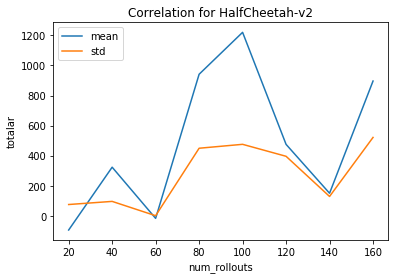

In [19]:
draw_graph(ans, list(range(20, 180, 20)))

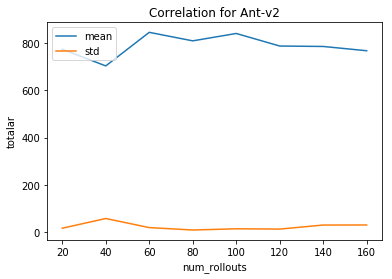

In [25]:
draw_graph(ans, list(range(20, 180, 20)))

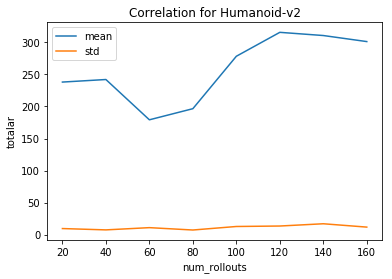

In [31]:
draw_graph(ans, list(range(20, 180, 20)))

__Задание 1.2.__ Выберите один из гиперапараметров вашей модели, которые влияют на качество обучения (количество эпох, количество слоев и т.п.). Для одного из окружений постройте график влияния значения этого параметра на качество обучения (totalr).

In [5]:
ans = []
for j in range(20, 30):
    data=generate_rollouts(num_rollouts=20,max_steps=100,render=False);
    x = data['observations']
    y = data['actions']

    x,y = shuffle(x,y)

    # create an object from BC_Model class, and train it
    cloner=BC_Model(x,y)
    cloner.train(j)

    num_eval_rollouts=10
    # loop over runouts
    returns=[]
    for i in range(num_eval_rollouts):
        # reset variables in each iteration
        totalr=0
        done=False
        obs=env.reset()
        # loop until the end of the episode
        while not done:
            # get an action from the trained model (output for specific observation as input)
            action=cloner.sample(obs)
            # implement the action
            obs,r,done,_=env.step(action)
            #env.render()
            totalr+=r
        returns.append(totalr)
    ans.append(returns)

mean return 642.7025345148575
std of return 9.481421214489014
mean return 641.9762452770372
std of return 8.184461228874472
mean return 644.4220958148937
std of return 8.878579465999788
mean return 643.783823445434
std of return 10.814275321539645
mean return 642.3926720341663
std of return 8.395201454736723
mean return 642.5859807739557
std of return 10.13233845347944
mean return 645.5147895721977
std of return 11.634941951861222
mean return 625.5394304849166
std of return 75.85994875752297
mean return 644.4427052512418
std of return 9.150701000224979
mean return 640.6396324635114
std of return 7.248590901910306


Text(0.5,1,'Correlation for Humanoid-v2')

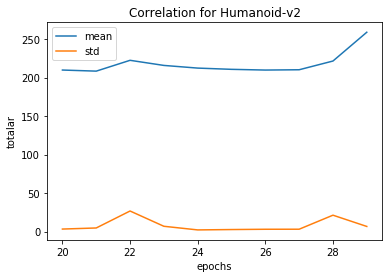

In [9]:
plt.plot(list(range(20, 30)),[np.mean(el) for el in ans])
plt.plot(list(range(20, 30)),[np.std(el) for el in ans])
plt.legend(['mean', 'std'], loc='upper left')

plt.xlabel('epochs')
plt.ylabel('totalar')
plt.title('Correlation for {0}'.format(env_name))

Судя по среднему значению на рассмотренном отрезке [20, 30], чем больше кол-во эпох, тем лучше 

***
## 2. DAgger Algorithm

Цель алгоритма DAgger (data Aggregation) - собрать статистику обучаемой модели, вместо экспертных данных. 
- Вначале мы тренируем BC_Model на собранных экспертных данных.
- Запускаем модель на окружениие, собираем наблюдения.
- Затем мы просим эксперта (человека) отметить, какие действия нужно совершать в полученных наблюдениях (по сути используем __policy_fn__).
- Создаем новую коллекцию помеченных и экспертных данных.
- Потворяем.

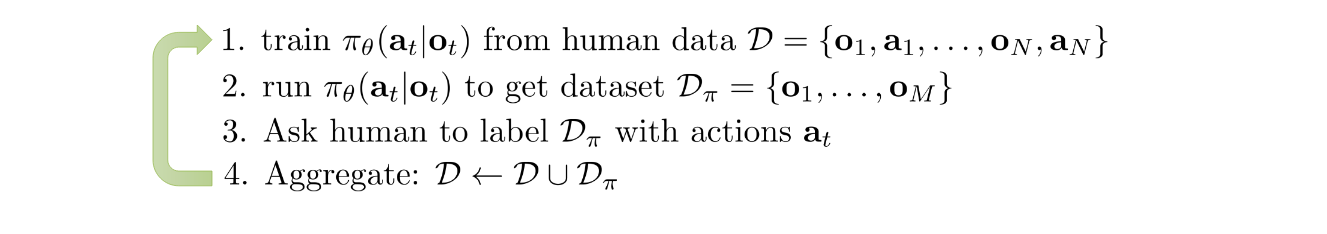

In [4]:
def DAgger(model, x, y):
    with tf.Session():
        DAgger_iter=5
        render=False
        # DAgger loop
        for i in range(DAgger_iter):
            # reset in each iteration
            new_obs = []
            new_actions = []
            obs = env.reset()
            done = False
            # collect data from model and expert
            while not done:
                # get an action from the model
                ### Ваш код здесь - испольузуем оубченную модель ###
                action = model.sample(obs)

                obs, _, done, _ = env.step(action)
                if render:
                    env.render()
                # get the expert action for the same input
                ### Ваш код здесь - испольузуем olicy_fn!! ###
                corrected_action = policy_fn(obs[None,:])

                # append the observation and expert action to the data set
                new_obs.append(obs)
                new_actions.append(corrected_action)
            # re-order the data
            x = np.concatenate((x, obs[None, :]), axis = 0)
            y = np.concatenate((y, corrected_action[None, :]), axis = 0)
            # train the model on the collected data
            ### Ваш код здесь - дообучаем модель ###
            model.train(train_data=x, test_data=y)
            
        return model

Так как обучение BC_Model происходило не в рамках tf.Session(), ядро падало и приходилось обучать пачками. Было поздно, когда я понял про tf.Session()

In [5]:
def check(model):
    num_eval_rollouts=10
    # loop over runouts
    returns=[]
    for i in range(num_eval_rollouts):
        # reset variables in each iteration
        totalr=0
        done=False
        obs=env.reset()
        # loop until the end of the episode
        while not done:
            # get an action from the trained model (output for specific observation as input)
            action=model.sample(obs)
            # implement the action
            obs,r,done,_=env.step(action)
            #env.render()
            totalr+=r
        returns.append(totalr)
    return returns


envs = ["Reacher-v2", "Walker2d-v2"]
res = {}
for env_name in envs:

    expert_policy_file="experts/"+env_name+".pkl"
    policy_fn = load_policy.load_policy(expert_policy_file)
    env = gym.make(env_name)

    bc_mean = []
    bc_std = []
    
    dgr_mean = []
    dgr_std = []
    
    for i in range(20, 180, 20):
        data=generate_rollouts(num_rollouts=i,max_steps=100,render=False);
        x = data['observations']
        y = data['actions']
        x,y = shuffle(x,y)

        model = BC_Model(x, y)
        model.train()

        bc = check(model)
        bc_mean.append(np.mean(bc))
        bc_std.append(np.std(bc))
        
        model = DAgger(model, x, y)
        
        dgr = check(model)
        dgr_mean.append(np.mean(dgr))
        dgr_std.append(np.std(dgr))
        
    with open("{0}.txt".format(env_name), "w") as received_data:
        for el in bc_mean:
            received_data.write("%d " % el)
        received_data.write("\n")
        for el in bc_std:
            received_data.write("%d " % el)
        received_data.write("\n")
        for el in dgr_mean:
            received_data.write("%d " % el)
        received_data.write("\n")
        for el in dgr_std:
            received_data.write("%d " % el)
        received_data.write("\n")
    

obs (1, 11) (1, 11)
Instructions for updating:
Please use tf.global_variables instead.
Instructions for updating:
Use `tf.variables_initializer` instead.


/home/pabramov/Programms/anaconda3/lib/python3.6/site-packages/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


mean return -4.153740095187607
std of return 1.9974588771221438
mean return -4.010833646984645
std of return 1.8173769441518037
mean return -3.7867617196176493
std of return 1.5577696526872125
mean return -3.7071304036592223
std of return 1.6505409187151492
mean return -3.801847240799313
std of return 1.7546488928812398
mean return -3.9879073044479694
std of return 1.657394166239534
mean return -3.458918507763871
std of return 1.7551044859821863
mean return -4.15623112919179
std of return 1.6787052641446143
obs (1, 17) (1, 17)
mean return 221.3159552057983
std of return 1.3978314527255853
mean return 221.75395011175684
std of return 1.4054740160229402
mean return 221.53265894203227
std of return 1.4129758771304228
mean return 221.5422668218739
std of return 1.3961915501231825
mean return 221.29521185972106
std of return 1.359323411676835
mean return 221.3572049861764
std of return 1.2454252624492999
mean return 221.339049761978
std of return 1.393575242638886
mean return 221.2629802849

__Задание 2.1.__ Проверьте работу DAagger на всех задачах MoJoCo - укажите для какой задачи он работает лучше, чем простое клонирование. Покажите это на графиках.

<i>Считаем std и mean для выборки по изменению num_rollouts</i>

In [48]:
def draw(a, b, c, d, env):
    
    fig, axes = plt.subplots(ncols=2)

    fig.text(0.5, 0.04, 'num_rollouts', ha='center')
    fig.text(0.04, 0.5, 'totalr', va='center', rotation='vertical')
    fig.text(0.5, 1, 'Mean and std comparison for {0}'.format(env), ha='center')    
    
    l = list(range(20, 180, 20))
    
    axes[0].plot(l, a)
    axes[0].plot(l, b)
    axes[0].legend(['BC_Model', 'DAgger'], loc='upper left')

    axes[1].plot(l, c)
    axes[1].plot(l, d)
    axes[1].legend(['BC_Model', 'DAgger'], loc='upper left')


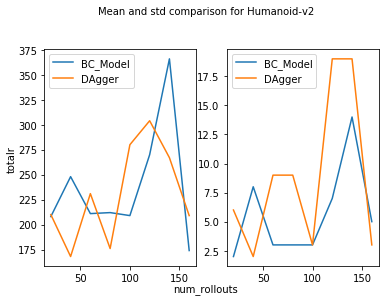

In [50]:
env_name="Humanoid-v2"

with open("{0}.txt".format(env_name), "r") as f:
    content = f.readlines()

bc_mean = [int(x) for x in content[0].split()]
bc_std = [int(x) for x in content[1].split()]
dagger_mean = [int(x) for x in content[2].split()]
dagger_std = [int(x) for x in content[3].split()]


draw(bc_mean, dagger_mean, bc_std, dagger_std, env_name)

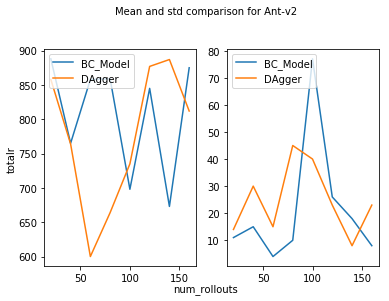

In [51]:
env_name="Ant-v2"

with open("{0}.txt".format(env_name), "r") as f:
    content = f.readlines()

bc_mean = [int(x) for x in content[0].split()]
bc_std = [int(x) for x in content[1].split()]
dagger_mean = [int(x) for x in content[2].split()]
dagger_std = [int(x) for x in content[3].split()]


draw(bc_mean, dagger_mean, bc_std, dagger_std, env_name)

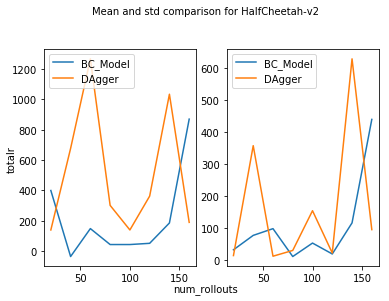

In [52]:
env_name="HalfCheetah-v2"

with open("{0}.txt".format(env_name), "r") as f:
    content = f.readlines()

bc_mean = [int(x) for x in content[0].split()]
bc_std = [int(x) for x in content[1].split()]
dagger_mean = [int(x) for x in content[2].split()]
dagger_std = [int(x) for x in content[3].split()]


draw(bc_mean, dagger_mean, bc_std, dagger_std, env_name)

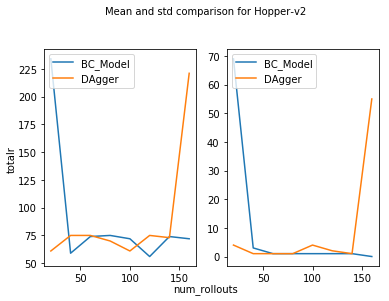

In [53]:
env_name="Hopper-v2"

with open("{0}.txt".format(env_name), "r") as f:
    content = f.readlines()

bc_mean = [int(x) for x in content[0].split()]
bc_std = [int(x) for x in content[1].split()]
dagger_mean = [int(x) for x in content[2].split()]
dagger_std = [int(x) for x in content[3].split()]


draw(bc_mean, dagger_mean, bc_std, dagger_std, env_name)

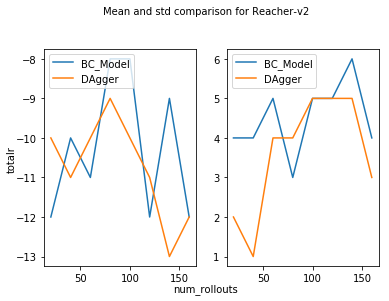

In [54]:
env_name="Reacher-v2"

with open("{0}.txt".format(env_name), "r") as f:
    content = f.readlines()

bc_mean = [int(x) for x in content[0].split()]
bc_std = [int(x) for x in content[1].split()]
dagger_mean = [int(x) for x in content[2].split()]
dagger_std = [int(x) for x in content[3].split()]


draw(bc_mean, dagger_mean, bc_std, dagger_std, env_name)

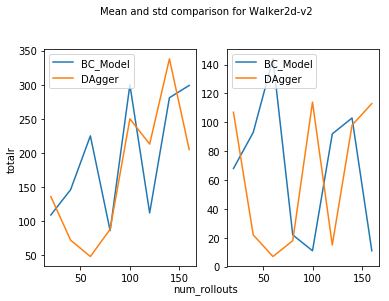

In [55]:
env_name="Walker2d-v2"

with open("{0}.txt".format(env_name), "r") as f:
    content = f.readlines()

bc_mean = [int(x) for x in content[0].split()]
bc_std = [int(x) for x in content[1].split()]
dagger_mean = [int(x) for x in content[2].split()]
dagger_std = [int(x) for x in content[3].split()]


draw(bc_mean, dagger_mean, bc_std, dagger_std, env_name)

### Вывод
DAgger pаботает лучше для HalfCheetah-v2